In [1]:
import numpy as np
import random

from utils.blackjack_env_builder import BlackJackStylised
from utils.scorer import Scorer, quadratic_scorer
from utils.evaluator import evaluate_agent
from tqdm import tqdm
from matplotlib import pyplot as plt
from utils.general import plot_q_values

from utils.evaluator import test_q_learning_agent

In [2]:


class BlackjackQLearningAgent:
    def __init__(self, num_states, num_actions, learning_rate=0.1, discount_factor=0.9, epsilon=0.1):
        self.Q = np.zeros((num_states, 2, num_actions)) 
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.num_actions = num_actions

    def choose_action(self, state):
        current_sum, usable_ace = state
        if random.random() < self.epsilon:
            return random.choice(range(self.num_actions))
        else:
            return np.argmax(self.Q[int(current_sum), usable_ace])

    def update(self, state, action, reward, next_state, done):
        current_sum, usable_ace = state
        next_sum, next_usable_ace = next_state

        old_value = self.Q[int(current_sum), usable_ace, action]
        next_max = np.max(self.Q[int(next_sum), usable_ace]) if not done else 0

        new_value = old_value + self.learning_rate * (reward + self.discount_factor * next_max - old_value)
        # self.oldQ = np.copy(self.Q)
        self.Q[int(current_sum), usable_ace, action] = new_value

            
            
# TODO
def get_deck_feature(card_counter):
    
    running_count = 0
    for card, info in card_counter.items():
        # print(f'card {card} info {info}')
        if card in ['2', '3', '4', '5', '6']:
            # print('cc', info['curr_count'])
            running_count += info['curr_count']
        elif card in ['10', 'J', 'Q', 'K', 'A']:
            # print('cc', info['curr_count'])
            running_count -= info['curr_count']

    # print('running count: ', running_count)
    if running_count <= -20:
        return 0  # Low count
    elif running_count <= 0:
        return 1  # Neutral
    else:
        return 2  # High count

def q_learning_has_converged(previous_Q, current_Q, threshold=0.001):
    
    previous_Q_temp = previous_Q.ravel()
    current_Q_temp = current_Q.ravel()
    # print(f' is check : {previous_Q_temp is current_Q_temp}')
    
    delta = np.abs(current_Q_temp - previous_Q_temp)  #np.abs(
    # print(current_Q - previous_Q)
    return np.sum(delta) < threshold

# Finite Deck Setting

In [3]:
# Example usage
num_states = 22  # 1 to 21 for card sum, and an additional state for bust
num_actions = 2  # Actions: 0 for stick, 1 for hit
discount_factor=0.95
epsilon = 1
min_epsilon = 0.05
max_epsilon = epsilon
decay_factor = 0.0005
finite_agent = BlackjackQLearningAgent(num_states, num_actions, discount_factor=discount_factor, epsilon=epsilon)

env = BlackJackStylised(num_decks=3)
max_episodes = 100000
converge_flag = False
for episode in tqdm(range(max_episodes)):
    cards, current_sum, usable_ace, hand_complete = env.reset_init(hard=True)
    state = (int(current_sum-1), int(usable_ace))
    done = hand_complete
    finite_agent.epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_factor*episode) 

    
    while not env.deck_complete: ## 1 episode
        while not done: ## 1 Hand
            if env.deck_complete:
                break
            action = finite_agent.choose_action(state)
            next_cards, next_sum, next_usable_ace, hand_complete = env.step(action)
            next_state = (next_sum-1, int(next_usable_ace))
            reward = 0 if not hand_complete else quadratic_scorer(next_sum)
            finite_agent.update(state, action, reward, next_state, hand_complete)
            
            state = next_state
            done = hand_complete
        
        cards, current_sum, usable_ace, hand_complete = env.reset_init()
        
        state = (int(current_sum-1), int(usable_ace))

        

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:03<00:00, 810.98it/s]


In [16]:
def plot_q_values_(agent):
    x1 = range(2, 22)
    q_stick1 = [agent.Q[sum_val - 1, 0, 0] for sum_val in x1]
    q_hit1 = [agent.Q[sum_val - 1, 0, 1] for sum_val in x1]
 
    # Set 2
    x2 = range(2, 22)
    q_stick2 = [agent.Q[sum_val - 1, 1, 0] for sum_val in x2]
    q_hit2 = [agent.Q[sum_val - 1, 1, 1] for sum_val in x2]
 
    # Plot 1
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5))  # 2 rows, 1 column
    bar_width = 0.25
    bar_stick1 = [i - bar_width / 2 for i in x1]
    bar_hit1 = [i + bar_width / 2 for i in x1]
    ax1.bar(bar_stick1, q_stick1, bar_width, label='Stick')
    ax1.bar(bar_hit1, q_hit1, bar_width, label='Hit')
    ax1.set_xlabel('Current Sum')
    ax1.set_ylabel('Q-Value')
    ax1.set_title('Without Usable Ace')
    ax1.set_xticks(x1)
    ax1.set_xticklabels(x1)
    ax1.legend()
 
    # Plot 2
    bar_stick2 = [i - bar_width / 2 for i in x2]
    bar_hit2 = [i + bar_width / 2 for i in x2]
    ax2.bar(bar_stick2, q_stick2, bar_width, label='Stick')
    ax2.bar(bar_hit2, q_hit2, bar_width, label='Hit')
    ax2.set_xlabel('Current Sum')
    ax2.set_ylabel('Q-Value')
    ax2.set_title('With Usable Ace')
    ax2.set_xticks(x2)
    ax2.set_xticklabels(x2)
    ax2.legend()
 
    plt.tight_layout()  # Ensures subplots do not overlap
    plt.show()

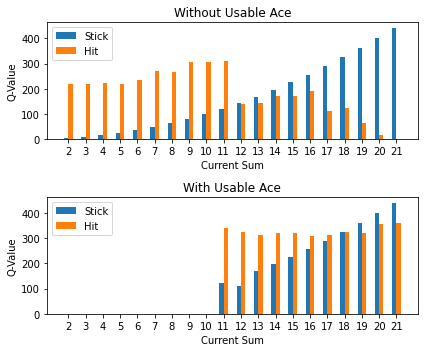

In [17]:
plot_q_values_(finite_agent)

In [5]:
evaluate_agent(n_eval_episodes=10000, Q=finite_agent.Q, num_decks=3, random_agent=False)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 969.19it/s]


(245.4154, 144.55417545972168)

In [7]:
test_q_learning_agent(finite_agent, env, num_hands=1000)

(0.0, 0.0)

# Infinite Deck Settings

In [8]:
# Example usage
num_states = 22  # 1 to 21 for card sum, and an additional state for bust
num_actions = 2  # Actions: 0 for stick, 1 for hit
discount_factor=0.95
epsilon = 1
min_epsilon = 0.05
max_epsilon = epsilon
decay_factor = 0.0005
infinite_agent = BlackjackQLearningAgent(num_states, num_actions, discount_factor=discount_factor, epsilon=epsilon)

# Assuming you have an instance of your environment
env = BlackJackStylised(num_decks=None)
max_episodes = 100000

for episode in tqdm(range(max_episodes)):
    cards, current_sum, usable_ace, hand_complete = env.reset_init(hard=True)
    # print(env.card_counter)
    # print(deck_feature)
    state = (int(current_sum-1), int(usable_ace))
    done = hand_complete
    infinite_agent.epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_factor*episode) 

    
    # while not env.deck_complete: ## 1 episode
    while not done: ## 1 Hand
        if env.deck_complete:
            break
        action = infinite_agent.choose_action(state)
        next_cards, next_sum, next_usable_ace, hand_complete = env.step(action)
        # next_deck_feature = get_deck_feature(env.card_counter)
        next_state = (next_sum-1, int(next_usable_ace))
        reward = 0 if not hand_complete else quadratic_scorer(next_sum)
        infinite_agent.update(state, action, reward, next_state, hand_complete)


        state = next_state
        done = hand_complete
        
    cards, current_sum, usable_ace, hand_complete = env.reset_init()

    state = (int(current_sum-1), int(usable_ace))


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:18<00:00, 5445.09it/s]


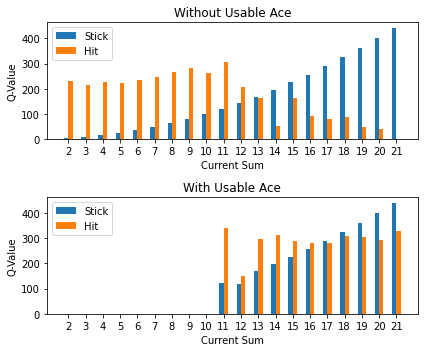

In [18]:
plot_q_values_(infinite_agent)

In [10]:
evaluate_agent(n_eval_episodes=10000, Q=infinite_agent.Q, num_decks=None, random_agent=False)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2204.35it/s]


(63.3658, 58.49359272911863)

## Random Agent Infinite Deck

In [11]:
evaluate_agent(n_eval_episodes=10000, random_agent=True)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 6789.11it/s]


(62.4486, 39.229756028300756)

## Random Agent finite Deck

In [5]:
evaluate_agent(n_eval_episodes=10000, num_decks=4, random_agent=True)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 766.50it/s]


(118.3938, 123.11977875857316)